# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2020.csv", encoding = 'utf-8')

ep_data = pd.read_csv("results/ep.csv", encoding = 'utf-8')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'utf-8')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'utf-8')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

In [5]:
for i in range(2012, 2021):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    if "ï»¿id" in drive.columns:
        drive["id"] = drive["ï»¿id"]
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    if "ï»¿id" in gm.columns:
        gm["id"] = gm["ï»¿id"]
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    if "ï»¿id" in plys.columns:
        plys["id"] = plys["ï»¿id"]
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}") # 171692
print(f"Total Plays: {len(pbp_data)}") # 1210147

Total Games: 7057
Total Drives: 172193
Total Plays: 1213874


In [6]:
croot_data = pd.DataFrame()

for i in range(2007, 2021):
    k = retrieveCfbDataFile('recruiting',i)
    croot_data = croot_data.append(k, sort=False)
    
    
def calc_rolling_avg(frame, y):
    return frame[(frame.year == (y-3))| (frame.year == (y-2)) | (frame.year == (y-1)) | (frame.year == y)].rating.mean()
def calculate_fcs_talent(year):
    return croot_data[(croot_data.year == (yr-3))| (croot_data.year == (yr-2)) | (croot_data.year == (yr-1)) | (croot_data.year == yr)].rating.quantile(.02)
def calculate_roster_talent(team, year):
    team_slice = croot_data[(croot_data.committedTo == team)]
    if (len(team_slice) == 0):
        return calculate_fcs_talent(year)
    return calc_rolling_avg(team_slice, year)
print(f"Total Croots: {len(croot_data)}")

Total Croots: 44156


In [7]:
production = pd.DataFrame()
for i in range(2020, 2021):
    k = retrieveCfbDataFile('production',i)
    k['YEAR'] = i
    production = production.append(k, sort=False) 


def calculate_returning_production(team, yr):
    team_slice = production[(production.TEAM == team) & (production.YEAR == yr)]
    if (len(team_slice) == 0):
        return production[(production.YEAR == yr)].OVERALL_PCT.quantile(.02)
    return team_slice.OVERALL_PCT.to_list()[0]

# print(f"Georgia Tech: {calculate_returning_production('Georgia Tech', 2020)}")
production

,OVERALL_RANK,TEAM,OVERALL_PCT,OFFENSE_PCT,OFFENSE_RANK,DEFENSE_PCT,DEFENSE_RANK,YEAR
0,1,Northwestern,84,88,6,80,23,2020
1,2,Georgia Tech,84,74,39,94,2,2020
2,3,Houston,83,73,42,93,3,2020
3,4,East Carolina,83,87,8,79,26,2020
4,5,USC,82,77,25,87,7,2020
...,...,...,...,...,...,...,...,...
125,126,Kansas,42,41,115,44,117,2020
126,127,LSU,42,30,128,54,92,2020
127,128,Air Force,42,46,107,38,122,2020
128,129,UTEP,41,39,118,44,119,2020


In [8]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes',"ï»¿offense","drive_number","start_yards_to_goal","end_yards_to_goal"], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)


drives.loc[
    drives.defense == drives.away_team, ['offense']
] = drives.home_team

drives.loc[
    drives.defense == drives.home_team, ['offense']
] = drives.away_team

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

Clean Drives: 171287


In [9]:
drives[(drives.index < 170795)].isna().any()

index             False
offense           False
defense           False
game_id           False
drive_id          False
scoring           False
start_period      False
start_yardline    False
end_period        False
end_yardline      False
plays             False
yards             False
drive_result      False
year              False
away_team         False
home_team         False
dtype: bool

In [10]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [11]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [12]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
#     pbp_data.EqPPP.fillna(value=0, inplace=True)

print("EqPPP MAX:", pbp_data.EqPPP.max())
print("EqPPP MIN:", pbp_data.EqPPP.min())

EqPPP MAX: 4.973592175868585
EqPPP MIN: -2.2070924397671785


In [13]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,year,ï»¿id,game_id,drive_number,play_number,offense_timeouts,defense_timeouts,yards_to_goal,scoring,EqPPP
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.178282
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.142649
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810527


In [14]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [15]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,game_id,drive_number,play_number,offense_timeouts,defense_timeouts,yards_to_goal,scoring,EqPPP,play_explosive,play_successful
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,False,False
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,False,False
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.178282,False,False
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.142649,True,True
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810527,False,True


In [16]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff',"KickoffEqPPP","KickoffIsoPPP","PuntEqPPP","PuntIsoPPP","KickoffReturnEqPPP","KickoffReturnIsoPPP","PuntReturnEqPPP","PuntReturnIsoPPP"]

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        'Plays' : [len(team_off_plays)],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

def determine_kick_ep(kick_yardline, distance, return_yards):
    return ep_data.iloc[max(min(100, int(kick_yardline + distance)), 0)].ep - ep_data.iloc[max(min(100, kick_yardline), 0)].ep - ep_data.iloc[max(min(100, int(return_yards)), 0)].ep

def determine_kick_return(row, play_value):
    if "touchback" in row.PlayText:
        return 25
    else:
        return play_value
    
def determine_punt_return(row, play_value):
    if "touchback" in row.PlayText:
        return 20
    else:
        return play_value

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net","EP"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = np.nan_to_num(tmp.values)
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x, kickoff_plays.yards_gained[x.Index]),axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
        kickoff_distance['EP'] = kickoff_distance.apply(lambda x: determine_kick_ep(kickoff_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    kick_eqppp = kickoff_distance[(kickoff_distance.Offense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Offense == team)]) > 0) else 0
    kick_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)].EP.mean()
    kick_ret_eqppp = kickoff_distance[(kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Defense == team)]) > 0) else 0
    kick_ret_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)]) > 0) else 0
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful","EP"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = np.nan_to_num(pt_tmp.values)
        punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x, punt_plays.yards_gained[x.Index]),axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        punt_distance['EP'] = punt_distance.apply(lambda x: determine_kick_ep(punt_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    punt_eqppp = punt_distance[(punt_distance.Offense == team)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team)]) > 0) else 0
    punt_isoppp = punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)]) > 0) else 0
    punt_ret_eqppp = punt_distance[(punt_distance.Defense == team)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team)]) > 0) else 0
    punt_ret_isoppp = punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)]) > 0) else 0
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'KickoffEqPPP' : [kick_eqppp],
        'KickoffIsoPPP' : [kick_isoppp],
        'KickoffReturnEqPPP' : [kick_ret_eqppp],
        'KickoffReturnIsoPPP' : [kick_ret_isoppp],
        
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr],
        'PuntEqPPP' : [punt_eqppp],
        'PuntIsoPPP' : [punt_isoppp],
        'PuntReturnEqPPP' : [punt_eqppp],
        'PuntReturnIsoPPP' : [punt_isoppp]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
#     print(team_stat_pack.IsoPPP)
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
#     return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)
    quant = (team_stat_pack.OffSRDiff * 0.37) + (team_stat_pack.ActualTODiff / team_stat_pack.Plays) * 0.21 + (team_stat_pack.KickoffEqPPP - team_stat_pack.KickoffReturnEqPPP) * 0.22 + (team_stat_pack.PuntEqPPP - team_stat_pack.PuntReturnEqPPP) * 0.20
    return translate(quant, -10, 10, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
#     return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    return translate(team_stat_pack.ExpTO - team_stat_pack.ActualTO, -5, 5, 0, 3.0) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3.0) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4.0)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)
def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.396825,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.097853,0.196935
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.368421,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.900918,-0.196935


In [17]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.026057,5.386628,4.863036,4.960309,5.097853,0.196935
1,Virginia Tech,4.857978,4.973943,4.613372,5.136679,5.027691,4.900918,-0.196935


In [18]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

stored_game_boxes.Team = stored_game_boxes.Team.apply(lambda x: "San Jose State" if ((x == "San JosÃÂÃÂ© State") | (x == "San JosÃÂ© State")) else x)
if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 4504 box score groups by GameID.
[1/4504] Updating 5FR Margin for game_id 322430238...
[1/4504] Updated 5FR Margin for game_id 322430238.
[2/4504] Updating 5FR Margin for game_id 322430242...
[2/4504] Updated 5FR Margin for game_id 322430242.
[3/4504] Updating 5FR Margin for game_id 322432006...
[3/4504] Updated 5FR Margin for game_id 322432006.
[4/4504] Updating 5FR Margin for game_id 322432050...
[4/4504] Updated 5FR Margin for game_id 322432050.
[5/4504] Updating 5FR Margin for game_id 322432439...
[5/4504] Updated 5FR Margin for game_id 322432439.
[6/4504] Updating 5FR Margin for game_id 322440024...
[6/4504] Updated 5FR Margin for game_id 322440024.
[7/4504] Updating 5FR Margin for game_id 322442633...
[7/4504] Updated 5FR Margin for game_id 322442633.
[8/4504] Updating 5FR Margin for game_id 322450002...
[8/

/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[92/4504] Updated 5FR Margin for game_id 322590213.
[93/4504] Updating 5FR Margin for game_id 322590221...
[93/4504] Updated 5FR Margin for game_id 322590221.
[94/4504] Updating 5FR Margin for game_id 322590235...
[94/4504] Updated 5FR Margin for game_id 322590235.
[95/4504] Updating 5FR Margin for game_id 322590254...
[95/4504] Updated 5FR Margin for game_id 322590254.
[96/4504] Updating 5FR Margin for game_id 322590275...
[96/4504] Updated 5FR Margin for game_id 322590275.
[97/4504] Updating 5FR Margin for game_id 322590276...
[97/4504] Updated 5FR Margin for game_id 322590276.
[98/4504] Updating 5FR Margin for game_id 322590278...
[98/4504] Updated 5FR Margin for game_id 322590278.
[99/4504] Updating 5FR Margin for game_id 322590349...
[99/4504] Updated 5FR Margin for game_id 322590349.
[100/4504] Updating 5FR Margin for game_id 322592116...
[100/4504] Updated 5FR Margin for game_id 322592116.
[101/4504] Updating 5FR Margin for game_id 322592306...
[101/4504] Updated 5FR Margin for

[428/4504] Updated 5FR Margin for game_id 323152628.
[429/4504] Updating 5FR Margin for game_id 323152633...
[429/4504] Updated 5FR Margin for game_id 323152633.
[430/4504] Updating 5FR Margin for game_id 323152638...
[430/4504] Updated 5FR Margin for game_id 323152638.
[431/4504] Updating 5FR Margin for game_id 323152641...
[431/4504] Updated 5FR Margin for game_id 323152641.
[432/4504] Updating 5FR Margin for game_id 323200258...
[432/4504] Updated 5FR Margin for game_id 323200258.
[433/4504] Updating 5FR Margin for game_id 323212226...
[433/4504] Updated 5FR Margin for game_id 323212226.
[434/4504] Updating 5FR Margin for game_id 323220005...
[434/4504] Updated 5FR Margin for game_id 323220005.
[435/4504] Updating 5FR Margin for game_id 323220006...
[435/4504] Updated 5FR Margin for game_id 323220006.
[436/4504] Updating 5FR Margin for game_id 323220009...
[436/4504] Updated 5FR Margin for game_id 323220009.
[437/4504] Updating 5FR Margin for game_id 323220023...
[437/4504] Updated 

[688/4504] Updating 5FR Margin for game_id 332710326...
[688/4504] Updated 5FR Margin for game_id 332710326.
[689/4504] Updating 5FR Margin for game_id 332710333...
[689/4504] Updated 5FR Margin for game_id 332710333.
[690/4504] Updating 5FR Margin for game_id 332712050...
[690/4504] Updated 5FR Margin for game_id 332712050.
[691/4504] Updating 5FR Margin for game_id 332712084...
[691/4504] Updated 5FR Margin for game_id 332712084.
[692/4504] Updating 5FR Margin for game_id 332712116...
[692/4504] Updated 5FR Margin for game_id 332712116.
[693/4504] Updating 5FR Margin for game_id 332712348...
[693/4504] Updated 5FR Margin for game_id 332712348.
[694/4504] Updating 5FR Margin for game_id 332712433...
[694/4504] Updated 5FR Margin for game_id 332712433.
[695/4504] Updating 5FR Margin for game_id 332712440...
[695/4504] Updated 5FR Margin for game_id 332712440.
[696/4504] Updating 5FR Margin for game_id 332712483...
[696/4504] Updated 5FR Margin for game_id 332712483.
[697/4504] Updating

[958/4504] Updated 5FR Margin for game_id 333200242.
[959/4504] Updating 5FR Margin for game_id 333200251...
[959/4504] Updated 5FR Margin for game_id 333200251.
[960/4504] Updating 5FR Margin for game_id 333200259...
[960/4504] Updated 5FR Margin for game_id 333200259.
[961/4504] Updating 5FR Margin for game_id 333200344...
[961/4504] Updated 5FR Margin for game_id 333200344.
[962/4504] Updating 5FR Margin for game_id 333200356...
[962/4504] Updated 5FR Margin for game_id 333200356.
[963/4504] Updating 5FR Margin for game_id 333202032...
[963/4504] Updated 5FR Margin for game_id 333202032.
[964/4504] Updating 5FR Margin for game_id 333202247...
[964/4504] Updated 5FR Margin for game_id 333202247.
[965/4504] Updating 5FR Margin for game_id 333202305...
[965/4504] Updated 5FR Margin for game_id 333202305.
[966/4504] Updating 5FR Margin for game_id 333202306...
[966/4504] Updated 5FR Margin for game_id 333202306.
[967/4504] Updating 5FR Margin for game_id 333202426...
[967/4504] Updated 

[1235/4504] Updating 5FR Margin for game_id 400547895...
[1235/4504] Updated 5FR Margin for game_id 400547895.
[1236/4504] Updating 5FR Margin for game_id 400547896...
[1236/4504] Updated 5FR Margin for game_id 400547896.
[1237/4504] Updating 5FR Margin for game_id 400547897...
[1237/4504] Updated 5FR Margin for game_id 400547897.
[1238/4504] Updating 5FR Margin for game_id 400547899...
[1238/4504] Updated 5FR Margin for game_id 400547899.
[1239/4504] Updating 5FR Margin for game_id 400547901...
[1239/4504] Updated 5FR Margin for game_id 400547901.
[1240/4504] Updating 5FR Margin for game_id 400547902...
[1240/4504] Updated 5FR Margin for game_id 400547902.
[1241/4504] Updating 5FR Margin for game_id 400547903...
[1241/4504] Updated 5FR Margin for game_id 400547903.
[1242/4504] Updating 5FR Margin for game_id 400547906...
[1242/4504] Updated 5FR Margin for game_id 400547906.
[1243/4504] Updating 5FR Margin for game_id 400547907...
[1243/4504] Updated 5FR Margin for game_id 400547907.
[

[1502/4504] Updating 5FR Margin for game_id 400548306...
[1502/4504] Updated 5FR Margin for game_id 400548306.
[1503/4504] Updating 5FR Margin for game_id 400548307...
[1503/4504] Updated 5FR Margin for game_id 400548307.
[1504/4504] Updating 5FR Margin for game_id 400548308...
[1504/4504] Updated 5FR Margin for game_id 400548308.
[1505/4504] Updating 5FR Margin for game_id 400548310...
[1505/4504] Updated 5FR Margin for game_id 400548310.
[1506/4504] Updating 5FR Margin for game_id 400548311...
[1506/4504] Updated 5FR Margin for game_id 400548311.
[1507/4504] Updating 5FR Margin for game_id 400548312...
[1507/4504] Updated 5FR Margin for game_id 400548312.
[1508/4504] Updating 5FR Margin for game_id 400548314...
[1508/4504] Updated 5FR Margin for game_id 400548314.
[1509/4504] Updating 5FR Margin for game_id 400548315...
[1509/4504] Updated 5FR Margin for game_id 400548315.
[1510/4504] Updating 5FR Margin for game_id 400548316...
[1510/4504] Updated 5FR Margin for game_id 400548316.
[

[1758/4504] Updating 5FR Margin for game_id 400757026...
[1758/4504] Updated 5FR Margin for game_id 400757026.
[1759/4504] Updating 5FR Margin for game_id 400757028...
[1759/4504] Updated 5FR Margin for game_id 400757028.
[1760/4504] Updating 5FR Margin for game_id 400757029...
[1760/4504] Updated 5FR Margin for game_id 400757029.
[1761/4504] Updating 5FR Margin for game_id 400757030...
[1761/4504] Updated 5FR Margin for game_id 400757030.
[1762/4504] Updating 5FR Margin for game_id 400757031...
[1762/4504] Updated 5FR Margin for game_id 400757031.
[1763/4504] Updating 5FR Margin for game_id 400757032...
[1763/4504] Updated 5FR Margin for game_id 400757032.
[1764/4504] Updating 5FR Margin for game_id 400757033...
[1764/4504] Updated 5FR Margin for game_id 400757033.
[1765/4504] Updating 5FR Margin for game_id 400757034...
[1765/4504] Updated 5FR Margin for game_id 400757034.
[1766/4504] Updating 5FR Margin for game_id 400757036...
[1766/4504] Updated 5FR Margin for game_id 400757036.
[

[2003/4504] Updating 5FR Margin for game_id 400764891...
[2003/4504] Updated 5FR Margin for game_id 400764891.
[2004/4504] Updating 5FR Margin for game_id 400764894...
[2004/4504] Updated 5FR Margin for game_id 400764894.
[2005/4504] Updating 5FR Margin for game_id 400764895...
[2005/4504] Updated 5FR Margin for game_id 400764895.
[2006/4504] Updating 5FR Margin for game_id 400764896...
[2006/4504] Updated 5FR Margin for game_id 400764896.
[2007/4504] Updating 5FR Margin for game_id 400764898...
[2007/4504] Updated 5FR Margin for game_id 400764898.
[2008/4504] Updating 5FR Margin for game_id 400764899...
[2008/4504] Updated 5FR Margin for game_id 400764899.
[2009/4504] Updating 5FR Margin for game_id 400764900...
[2009/4504] Updated 5FR Margin for game_id 400764900.
[2010/4504] Updating 5FR Margin for game_id 400764901...
[2010/4504] Updated 5FR Margin for game_id 400764901.
[2011/4504] Updating 5FR Margin for game_id 400764902...
[2011/4504] Updated 5FR Margin for game_id 400764902.
[

[2310/4504] Updating 5FR Margin for game_id 400869142...
[2310/4504] Updated 5FR Margin for game_id 400869142.
[2311/4504] Updating 5FR Margin for game_id 400869143...
[2311/4504] Updated 5FR Margin for game_id 400869143.
[2312/4504] Updating 5FR Margin for game_id 400869144...
[2312/4504] Updated 5FR Margin for game_id 400869144.
[2313/4504] Updating 5FR Margin for game_id 400869145...
[2313/4504] Updated 5FR Margin for game_id 400869145.
[2314/4504] Updating 5FR Margin for game_id 400869146...
[2314/4504] Updated 5FR Margin for game_id 400869146.
[2315/4504] Updating 5FR Margin for game_id 400869147...
[2315/4504] Updated 5FR Margin for game_id 400869147.
[2316/4504] Updating 5FR Margin for game_id 400869148...
[2316/4504] Updated 5FR Margin for game_id 400869148.
[2317/4504] Updating 5FR Margin for game_id 400869149...
[2317/4504] Updated 5FR Margin for game_id 400869149.
[2318/4504] Updating 5FR Margin for game_id 400869150...
[2318/4504] Updated 5FR Margin for game_id 400869150.
[

[2658/4504] Updated 5FR Margin for game_id 400869687.
[2659/4504] Updating 5FR Margin for game_id 400869688...
[2659/4504] Updated 5FR Margin for game_id 400869688.
[2660/4504] Updating 5FR Margin for game_id 400869689...
[2660/4504] Updated 5FR Margin for game_id 400869689.
[2661/4504] Updating 5FR Margin for game_id 400869690...
[2661/4504] Updated 5FR Margin for game_id 400869690.
[2662/4504] Updating 5FR Margin for game_id 400869691...
[2662/4504] Updated 5FR Margin for game_id 400869691.
[2663/4504] Updating 5FR Margin for game_id 400869692...
[2663/4504] Updated 5FR Margin for game_id 400869692.
[2664/4504] Updating 5FR Margin for game_id 400869695...
[2664/4504] Updated 5FR Margin for game_id 400869695.
[2665/4504] Updating 5FR Margin for game_id 400869696...
[2665/4504] Updated 5FR Margin for game_id 400869696.
[2666/4504] Updating 5FR Margin for game_id 400869697...
[2666/4504] Updated 5FR Margin for game_id 400869697.
[2667/4504] Updating 5FR Margin for game_id 400869698...
[

[2909/4504] Updated 5FR Margin for game_id 400935282.
[2910/4504] Updating 5FR Margin for game_id 400935284...
[2910/4504] Updated 5FR Margin for game_id 400935284.
[2911/4504] Updating 5FR Margin for game_id 400935285...
[2911/4504] Updated 5FR Margin for game_id 400935285.
[2912/4504] Updating 5FR Margin for game_id 400935286...
[2912/4504] Updated 5FR Margin for game_id 400935286.
[2913/4504] Updating 5FR Margin for game_id 400935287...
[2913/4504] Updated 5FR Margin for game_id 400935287.
[2914/4504] Updating 5FR Margin for game_id 400935288...
[2914/4504] Updated 5FR Margin for game_id 400935288.
[2915/4504] Updating 5FR Margin for game_id 400935291...
[2915/4504] Updated 5FR Margin for game_id 400935291.
[2916/4504] Updating 5FR Margin for game_id 400935292...
[2916/4504] Updated 5FR Margin for game_id 400935292.
[2917/4504] Updating 5FR Margin for game_id 400935294...
[2917/4504] Updated 5FR Margin for game_id 400935294.
[2918/4504] Updating 5FR Margin for game_id 400935296...
[

[3171/4504] Updating 5FR Margin for game_id 400941838...
[3171/4504] Updated 5FR Margin for game_id 400941838.
[3172/4504] Updating 5FR Margin for game_id 400941839...
[3172/4504] Updated 5FR Margin for game_id 400941839.
[3173/4504] Updating 5FR Margin for game_id 400941840...
[3173/4504] Updated 5FR Margin for game_id 400941840.
[3174/4504] Updating 5FR Margin for game_id 400941841...
[3174/4504] Updated 5FR Margin for game_id 400941841.
[3175/4504] Updating 5FR Margin for game_id 400941842...
[3175/4504] Updated 5FR Margin for game_id 400941842.
[3176/4504] Updating 5FR Margin for game_id 400941843...
[3176/4504] Updated 5FR Margin for game_id 400941843.
[3177/4504] Updating 5FR Margin for game_id 400941845...
[3177/4504] Updated 5FR Margin for game_id 400941845.
[3178/4504] Updating 5FR Margin for game_id 400941846...
[3178/4504] Updated 5FR Margin for game_id 400941846.
[3179/4504] Updating 5FR Margin for game_id 400941847...
[3179/4504] Updated 5FR Margin for game_id 400941847.
[

[3421/4504] Updating 5FR Margin for game_id 401012757...
[3421/4504] Updated 5FR Margin for game_id 401012757.
[3422/4504] Updating 5FR Margin for game_id 401012758...
[3422/4504] Updated 5FR Margin for game_id 401012758.
[3423/4504] Updating 5FR Margin for game_id 401012759...
[3423/4504] Updated 5FR Margin for game_id 401012759.
[3424/4504] Updating 5FR Margin for game_id 401012760...
[3424/4504] Updated 5FR Margin for game_id 401012760.
[3425/4504] Updating 5FR Margin for game_id 401012761...
[3425/4504] Updated 5FR Margin for game_id 401012761.
[3426/4504] Updating 5FR Margin for game_id 401012763...
[3426/4504] Updated 5FR Margin for game_id 401012763.
[3427/4504] Updating 5FR Margin for game_id 401012764...
[3427/4504] Updated 5FR Margin for game_id 401012764.
[3428/4504] Updating 5FR Margin for game_id 401012765...
[3428/4504] Updated 5FR Margin for game_id 401012765.
[3429/4504] Updating 5FR Margin for game_id 401012766...
[3429/4504] Updated 5FR Margin for game_id 401012766.
[

[3670/4504] Updating 5FR Margin for game_id 401013448...
[3670/4504] Updated 5FR Margin for game_id 401013448.
[3671/4504] Updating 5FR Margin for game_id 401013450...
[3671/4504] Updated 5FR Margin for game_id 401013450.
[3672/4504] Updating 5FR Margin for game_id 401013451...
[3672/4504] Updated 5FR Margin for game_id 401013451.
[3673/4504] Updating 5FR Margin for game_id 401013452...
[3673/4504] Updated 5FR Margin for game_id 401013452.
[3674/4504] Updating 5FR Margin for game_id 401013466...
[3674/4504] Updated 5FR Margin for game_id 401013466.
[3675/4504] Updating 5FR Margin for game_id 401013490...
[3675/4504] Updated 5FR Margin for game_id 401013490.
[3676/4504] Updating 5FR Margin for game_id 401013491...
[3676/4504] Updated 5FR Margin for game_id 401013491.
[3677/4504] Updating 5FR Margin for game_id 401014974...
[3677/4504] Updated 5FR Margin for game_id 401014974.
[3678/4504] Updating 5FR Margin for game_id 401014975...
[3678/4504] Updated 5FR Margin for game_id 401014975.
[

[3926/4504] Updated 5FR Margin for game_id 401110779.
[3927/4504] Updating 5FR Margin for game_id 401110780...
[3927/4504] Updated 5FR Margin for game_id 401110780.
[3928/4504] Updating 5FR Margin for game_id 401110781...
[3928/4504] Updated 5FR Margin for game_id 401110781.
[3929/4504] Updating 5FR Margin for game_id 401110783...
[3929/4504] Updated 5FR Margin for game_id 401110783.
[3930/4504] Updating 5FR Margin for game_id 401110784...
[3930/4504] Updated 5FR Margin for game_id 401110784.
[3931/4504] Updating 5FR Margin for game_id 401110786...
[3931/4504] Updated 5FR Margin for game_id 401110786.
[3932/4504] Updating 5FR Margin for game_id 401110788...
[3932/4504] Updated 5FR Margin for game_id 401110788.
[3933/4504] Updating 5FR Margin for game_id 401110789...
[3933/4504] Updated 5FR Margin for game_id 401110789.
[3934/4504] Updating 5FR Margin for game_id 401110792...
[3934/4504] Updated 5FR Margin for game_id 401110792.
[3935/4504] Updating 5FR Margin for game_id 401110798...
[

[4172/4504] Updating 5FR Margin for game_id 401112500...
[4172/4504] Updated 5FR Margin for game_id 401112500.
[4173/4504] Updating 5FR Margin for game_id 401112501...
[4173/4504] Updated 5FR Margin for game_id 401112501.
[4174/4504] Updating 5FR Margin for game_id 401112503...
[4174/4504] Updated 5FR Margin for game_id 401112503.
[4175/4504] Updating 5FR Margin for game_id 401112505...
[4175/4504] Updated 5FR Margin for game_id 401112505.
[4176/4504] Updating 5FR Margin for game_id 401112506...
[4176/4504] Updated 5FR Margin for game_id 401112506.
[4177/4504] Updating 5FR Margin for game_id 401112507...
[4177/4504] Updated 5FR Margin for game_id 401112507.
[4178/4504] Updating 5FR Margin for game_id 401112509...
[4178/4504] Updated 5FR Margin for game_id 401112509.
[4179/4504] Updating 5FR Margin for game_id 401112512...
[4179/4504] Updated 5FR Margin for game_id 401112512.
[4180/4504] Updating 5FR Margin for game_id 401112513...
[4180/4504] Updated 5FR Margin for game_id 401112513.
[

[4413/4504] Updating 5FR Margin for game_id 401117902...
[4413/4504] Updated 5FR Margin for game_id 401117902.
[4414/4504] Updating 5FR Margin for game_id 401117903...
[4414/4504] Updated 5FR Margin for game_id 401117903.
[4415/4504] Updating 5FR Margin for game_id 401117904...
[4415/4504] Updated 5FR Margin for game_id 401117904.
[4416/4504] Updating 5FR Margin for game_id 401117905...
[4416/4504] Updated 5FR Margin for game_id 401117905.
[4417/4504] Updating 5FR Margin for game_id 401117907...
[4417/4504] Updated 5FR Margin for game_id 401117907.
[4418/4504] Updating 5FR Margin for game_id 401117908...
[4418/4504] Updated 5FR Margin for game_id 401117908.
[4419/4504] Updating 5FR Margin for game_id 401117909...
[4419/4504] Updated 5FR Margin for game_id 401117909.
[4420/4504] Updating 5FR Margin for game_id 401117910...
[4420/4504] Updated 5FR Margin for game_id 401117910.
[4421/4504] Updating 5FR Margin for game_id 401117911...
[4421/4504] Updated 5FR Margin for game_id 401117911.
[

[Local] Wrote updated box scores to file.


In [19]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,4.968386,4.842944,4.629272,4.134715,4.968386,4.842944,5.299631,0.617590,0.844447,2.041125
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-4.968386,-4.842944,-4.629272,-4.134715,-4.968386,-4.842944,4.660169,-0.617590,0.844447,2.041125
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,3.471563,2.354973,0.969049,1.381137,3.471563,2.354973,5.286086,0.603619,0.825343,0.194393
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,-3.471563,-2.354973,-0.969049,-1.381137,-3.471563,-2.354973,4.686914,-0.603619,0.825343,0.194393
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,3.498718,3.709156,1.714467,1.340515,3.498718,3.709156,4.829640,-0.351666,0.480841,0.534580


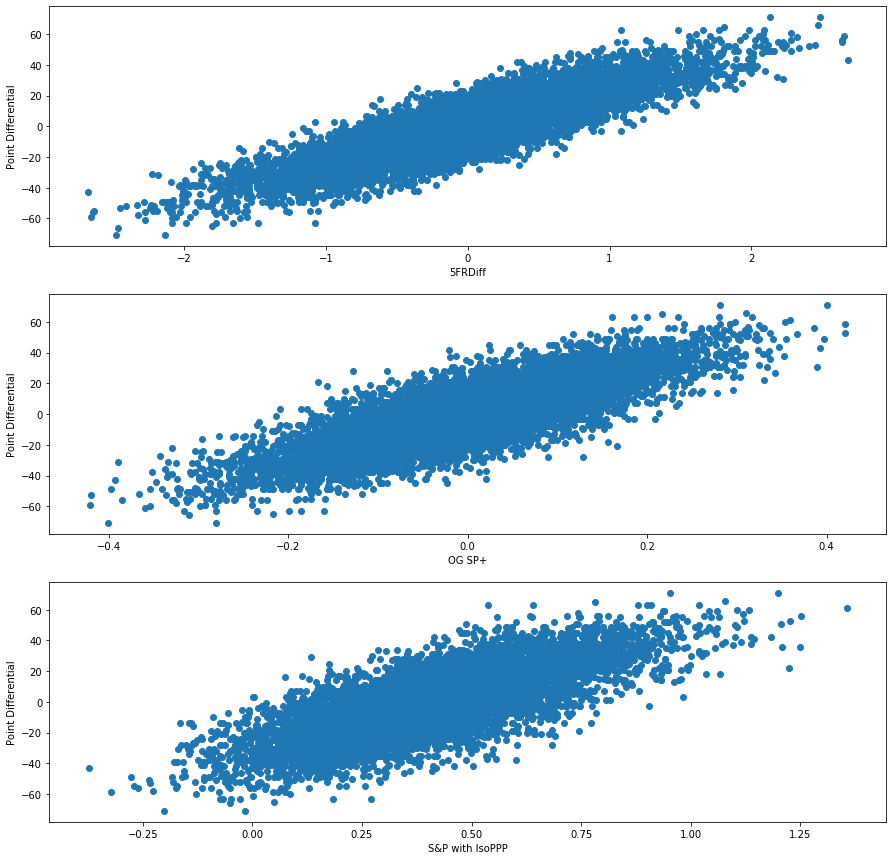

In [20]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [21]:
# fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
# fg.update_layout(
#     title="5FR Margin vs Point Margin (2012-2019)",
#     xaxis_title="5FR Margin",
#     yaxis_title="Point Margin")
# fg.show()
print("AVG MOV:", stored_game_boxes.PtsDiff.mean())
print("MOV STDDEV:", stored_game_boxes.PtsDiff.std())

AVG MOV: 0.0
MOV STDDEV: 20.578029850661


In [22]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.905984,0.739098
S&PIsoPPPDiff,0.905984,1.000000,0.799002
PtsDiff,0.739098,0.799002,1.000000


In [23]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,4.968386,4.842944,4.629272,4.134715,4.968386,4.842944,5.299631,0.617590,0.844447,2.041125
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-4.968386,-4.842944,-4.629272,-4.134715,-4.968386,-4.842944,4.660169,-0.617590,0.844447,2.041125
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,3.471563,2.354973,0.969049,1.381137,3.471563,2.354973,5.286086,0.603619,0.825343,0.194393
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,-3.471563,-2.354973,-0.969049,-1.381137,-3.471563,-2.354973,4.686914,-0.603619,0.825343,0.194393
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,3.498718,3.709156,1.714467,1.340515,3.498718,3.709156,4.829640,-0.351666,0.480841,0.534580


In [24]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [25]:
# outliers

In [26]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-4.968386,-4.842944,-4.629272,-4.134715,-4.968386,-4.842944,4.660169,-0.617590,0.844447,2.041125
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,3.471563,2.354973,0.969049,1.381137,3.471563,2.354973,5.286086,0.603619,0.825343,0.194393
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,-3.471563,-2.354973,-0.969049,-1.381137,-3.471563,-2.354973,4.686914,-0.603619,0.825343,0.194393
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,3.498718,3.709156,1.714467,1.340515,3.498718,3.709156,4.829640,-0.351666,0.480841,0.534580
5,Ball State,2012,322432050,37.0,11.0,0.979920,96,0.510417,0.083333,6.291667,...,-3.498718,-3.709156,-1.714467,-1.340515,-3.498718,-3.709156,5.170360,0.351666,0.480841,0.534580


In [27]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [28]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Linear Regression: y = 24.46400x + 0.05818
Mean Pred Score: 0.33989791190570817
Pred Std Dev: 17.59293098328302
Mean Abs Error: 7.87997481395315
Mdn Abs Error: 6.593805379175574
R-squared: 0.7587467136512946
Adj R-squared: 0.758613718454851



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.742102,0.541867,0.479857,0.776509,0.584447,0.590122,0.983202,0.511801,0.758808,...,-0.148478,-0.150238,-0.170597,-0.121577,-0.148478,-0.150238,-0.170597,0.863822,0.871185,0.871185
OffSRDiff,0.742102,1.000000,0.450123,0.264810,0.666745,0.355747,0.392999,0.740258,0.750248,0.695894,...,-0.132972,-0.136219,-0.146138,-0.131481,-0.132972,-0.136219,-0.146138,0.955083,0.949696,0.949696
OffERDiff,0.541867,0.450123,1.000000,0.121660,0.456640,0.283210,0.320159,0.533934,0.352726,0.801010,...,-0.083556,-0.076521,-0.091405,-0.082804,-0.083556,-0.076521,-0.091405,0.531795,0.515299,0.515299
FPDiff,0.479857,0.264810,0.121660,1.000000,0.603602,0.076900,0.066676,0.456230,0.020300,0.207005,...,-0.046042,-0.041617,-0.072544,0.023782,-0.046042,-0.041617,-0.072544,0.345878,0.359967,0.359967
OppRateDiff,0.776509,0.666745,0.456640,0.603602,1.000000,0.162549,0.161457,0.776946,0.241632,0.632854,...,-0.146336,-0.142062,-0.162571,-0.123915,-0.146336,-0.142062,-0.162571,0.745401,0.750178,0.750178
OppEffDiff,0.584447,0.355747,0.283210,0.076900,0.162549,1.000000,0.734925,0.580270,0.441575,0.401368,...,-0.073726,-0.081253,-0.090027,-0.065285,-0.073726,-0.081253,-0.090027,0.479004,0.487492,0.487492
OppPPDDiff,0.590122,0.392999,0.320159,0.066676,0.161457,0.734925,1.000000,0.595701,0.524067,0.448632,...,-0.082944,-0.100348,-0.110895,-0.067031,-0.082944,-0.100348,-0.110895,0.561498,0.568414,0.568414
PPDDiff,0.983202,0.740258,0.533934,0.456230,0.776946,0.580270,0.595701,1.000000,0.509637,0.751623,...,-0.154075,-0.153078,-0.172922,-0.129074,-0.154075,-0.153078,-0.172922,0.862395,0.869825,0.869825
OppSRDiff,0.511801,0.750248,0.352726,0.020300,0.241632,0.441575,0.524067,0.509637,1.000000,0.537144,...,-0.062025,-0.069887,-0.073173,-0.058009,-0.062025,-0.069887,-0.073173,0.737001,0.730358,0.730358
YPPDiff,0.758808,0.695894,0.801010,0.207005,0.632854,0.401368,0.448632,0.751623,0.537144,1.000000,...,-0.128826,-0.124014,-0.131552,-0.123746,-0.128826,-0.124014,-0.131552,0.785656,0.770022,0.770022


In [29]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.724463,0.742102,0.694058,0.901797,0.702349,0.431475,0.863822,0.871185,0.871185
ActPts,0.724463,1.000000,0.543590,0.497802,0.654508,0.513260,0.320526,0.630125,0.636225,0.636225
Eff,0.742102,0.543590,1.000000,0.620781,0.775103,0.993923,0.306917,0.955083,0.949696,0.949696
Expl,0.694058,0.497802,0.620781,1.000000,0.671209,0.609532,0.241371,0.721927,0.702761,0.702761
FinDrv,0.901797,0.654508,0.775103,0.671209,1.000000,0.740836,0.411325,0.912884,0.918244,0.918244
FldPos,0.702349,0.513260,0.993923,0.609532,0.740836,1.000000,0.240988,0.931833,0.920454,0.920454
Trnovr,0.431475,0.320526,0.306917,0.241371,0.411325,0.240988,1.000000,0.451654,0.440149,0.440149
5FR,0.863822,0.630125,0.955083,0.721927,0.912884,0.931833,0.451654,1.000000,0.995533,0.995533
5FRDiff,0.871185,0.636225,0.949696,0.702761,0.918244,0.920454,0.440149,0.995533,1.000000,1.000000
PredPtsDiff,0.871185,0.636225,0.949696,0.702761,0.918244,0.920454,0.440149,0.995533,1.000000,1.000000


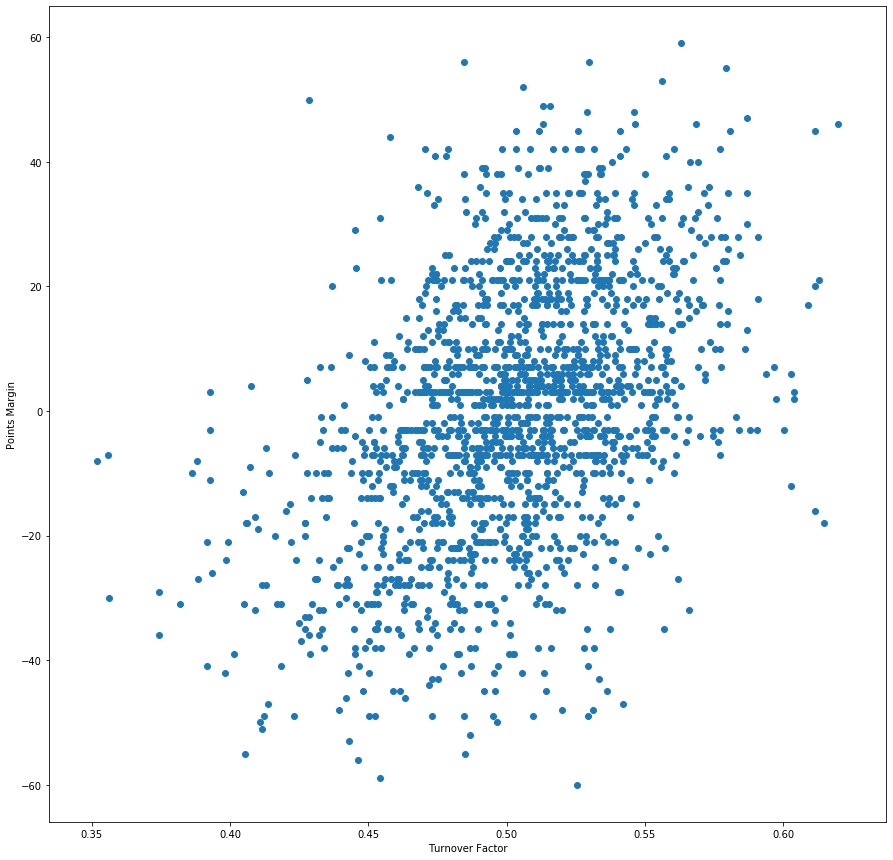

In [30]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

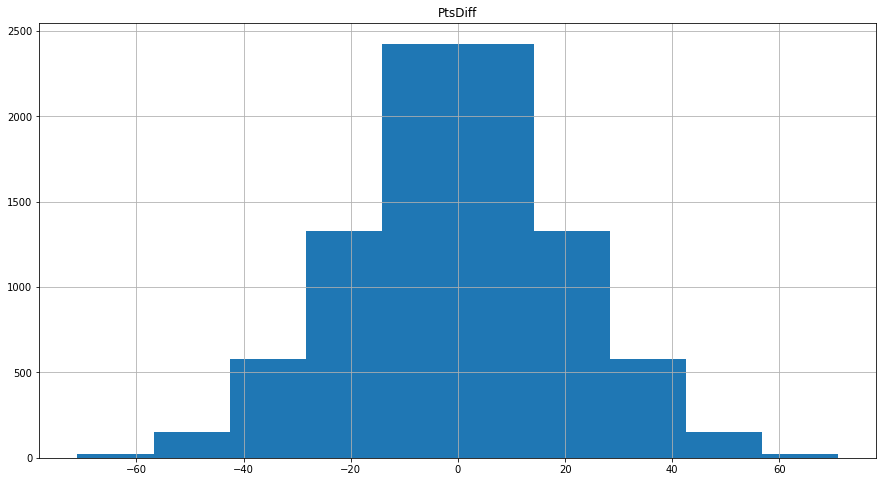

In [31]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

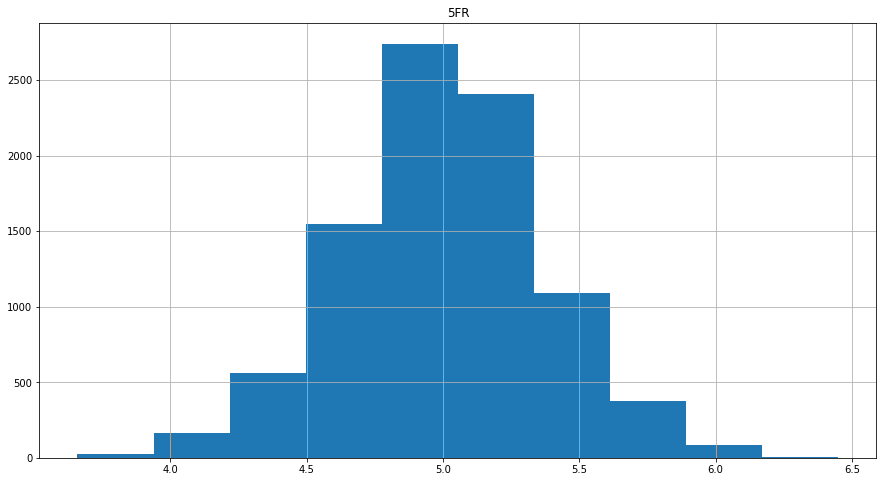

In [32]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

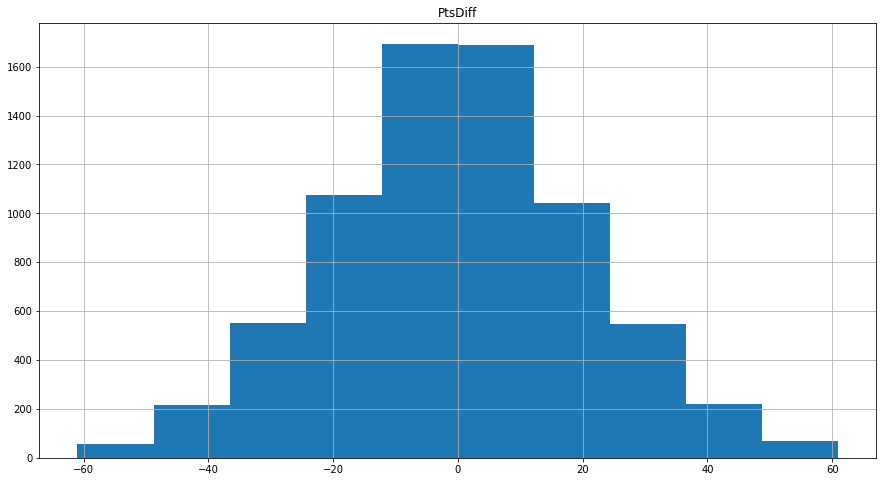

In [33]:
train_data.hist(column='PtsDiff', figsize=(15,8));

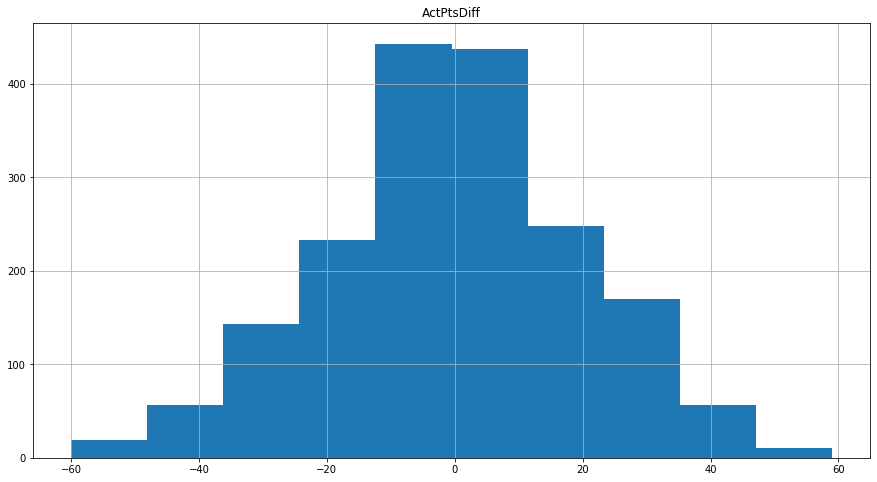

In [34]:
test.hist(column='ActPtsDiff', figsize=(15,8));

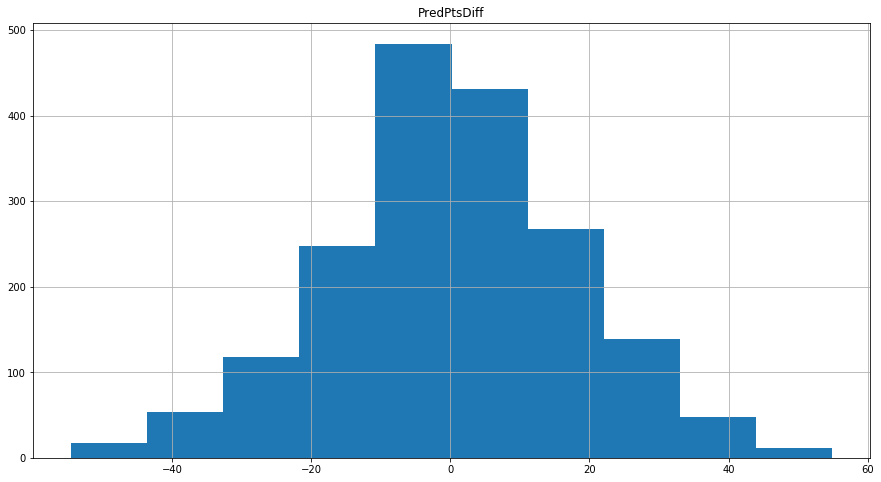

In [35]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [36]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [37]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -5.0 (exact value: -4.7596385615052474)
Z score: -0.2898628135503167
Win Prob for Virginia Tech: 38.60%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.396825,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.097853,0.196935
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.368421,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.900918,-0.196935


In [38]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -1.0 (exact value: -1.0713463579897813)
Z score: -0.08021655238893781
Win Prob for Georgia Tech: 46.80%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,63,0.396825,0.111111,5.460317,...,-0.933098,-1.377563,-1.340971,-1.271901,0.933098,1.377563,-1.340971,-1.271901,4.999713,-0.046171
1,Miami,2019,401112488,21.0,-7.0,0.934248,62,0.370968,0.112903,5.790323,...,0.933098,1.377563,1.340971,1.271901,-0.933098,-1.377563,1.340971,1.271901,5.045884,0.046171


In [39]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -2.0 (exact value: -1.665776735010704)
Z score: -0.11400457654396669
Win Prob for Georgia Tech: 45.46%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,80,0.487500,0.150000,5.712500,...,-0.897603,-1.173665,-0.611488,-0.611488,0.897603,1.173665,-0.611488,-0.611488,5.034688,0.070469
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,57,0.473684,0.140351,7.035088,...,0.897603,1.173665,0.611488,0.611488,-0.897603,-1.173665,0.611488,0.611488,4.964218,-0.070469


In [40]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 1.0 (exact value: 1.0598891496140492)
Z score: 0.040925030535985396
Win Prob for Mississippi State: 51.63%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,71,0.422535,0.070423,5.563380,...,-0.882085,-0.987754,0.250056,0.379959,0.882085,0.987754,0.250056,0.379959,4.967210,-0.040946
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,58,0.413793,0.137931,5.482759,...,0.882085,0.987754,-0.250056,-0.379959,-0.882085,-0.987754,-0.250056,-0.379959,5.008156,0.040946


In [41]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -4.0 (exact value: -3.8998195866465633)
Z score: -0.24098983293806436
Win Prob for Texas A&M: 40.48%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,90,0.466667,0.088889,5.511111,...,-1.387078,-1.436023,-0.277088,0.436788,1.387078,1.436023,-0.277088,0.436788,5.080587,0.161789
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,104,0.423077,0.105769,4.634615,...,1.387078,1.436023,0.277088,-0.436788,-1.387078,-1.436023,0.277088,-0.436788,4.918798,-0.161789


In [42]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.950178,13,12.0,1.0
2,LSU,0.944236,13,12.0,1.0
3,Alabama,0.920270,12,11.0,1.0
4,Oklahoma,0.887994,13,12.0,1.0
5,Clemson,0.886210,13,12.0,1.0
...,...,...,...,...,...
126,Akron,0.068610,12,1.0,11.0
127,Maryland,0.053115,12,1.0,11.0
128,Rutgers,0.042003,12,1.0,11.0
129,UMass,0.023584,12,0.0,12.0


In [43]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,10.649064,2.350936
53,LSU,9.866740,3.133260
78,Oklahoma,8.951631,4.048369
115,Utah,8.238266,4.761734
34,Georgia,7.507918,5.492082
...,...,...,...
55,Maryland,1.170331,10.829669
14,Bowling Green,1.128681,10.871319
88,Rutgers,0.745419,11.254581
112,UMass,0.516129,11.483871


In [44]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Florida State,2012,5.471601,1
1,Arizona State,2012,5.340806,2
2,Alabama,2012,5.290538,3
3,Boise State,2012,5.284705,4
4,Georgia,2012,5.257723,5
...,...,...,...,...
1021,Vanderbilt,2019,4.566785,126
1022,Akron,2019,4.486465,127
1023,Maryland,2019,4.433791,128
1024,Rutgers,2019,4.387626,129


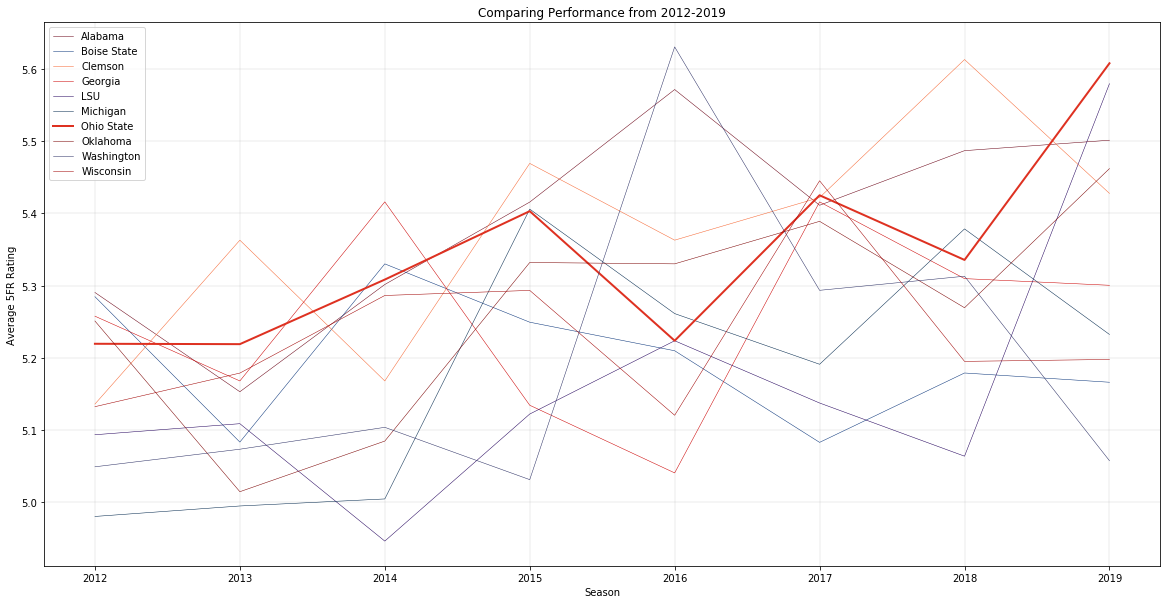

In [45]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [46]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.391519
1,Clemson,5.370278
2,Ohio State,5.342814
3,Oklahoma,5.266657
4,Georgia,5.255386
...,...,...
125,Texas State,4.776499
126,Rutgers,4.775176
127,UMass,4.750314
128,New Mexico State,4.733853


In [47]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
508,Washington,2016,5.630604,1
766,Clemson,2018,5.613102,1
896,Ohio State,2019,5.607933,1
125,Florida State,2013,5.600234,1
897,LSU,2019,5.579701,2
509,Alabama,2016,5.571564,2
510,Louisville,2016,5.521836,3
898,Alabama,2019,5.501394,3
767,NC State,2018,5.492035,2
768,Alabama,2018,5.486935,3


In [48]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
285,Georgia Tech,2014,5.123979,34
693,Georgia Tech,2017,5.037526,58
63,Georgia Tech,2012,4.985145,64
187,Georgia Tech,2013,4.971667,63
580,Georgia Tech,2016,4.955918,73
466,Georgia Tech,2015,4.882074,87
998,Georgia Tech,2019,4.835603,103
881,Georgia Tech,2018,4.733768,116


In [49]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322872751.0,Wyoming,2012.0,Air Force,4.0
4,322942005.0,New Mexico,2012.0,Air Force,5.0
...,...,...,...,...,...
8938,401117526.0,New Mexico,2019.0,Wyoming,6.0
8939,401117533.0,Nevada,2019.0,Wyoming,7.0
8940,401117541.0,Boise State,2019.0,Wyoming,8.0
8941,401117546.0,Utah State,2019.0,Wyoming,9.0


In [50]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False, adjust_covid = False):
    considered_weeks = week
    if (week <= 0):
        considered_weeks = 16 # consider all weeks
    
    applied_year = year
    if (week == 0):
        applied_year = applied_year - 1 
        
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == applied_year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == applied_year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    fcs_talent = calculate_fcs_talent(year)
    fcs_old_talent = calculate_fcs_talent(applied_year)
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    # Generate comparison attributes for team 1
    team1_talent = fcs_talent
    team1_old_talent = fcs_old_talent
    team1_avg_ffr = grouped_by_year.get_group((team1, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team1, applied_year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference) if (len(team1_record.conference) > 0) else "fcs"
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_talent = fcs_talent
        team1_old_talent = fcs_old_talent
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_talent = calculate_roster_talent(team1, year)
        team1_old_talent = calculate_roster_talent(team1, applied_year)
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_talent = fcs_talent
    team2_old_talent = fcs_old_talent
    team2_avg_ffr = grouped_by_year.get_group((team2, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team2, applied_year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference) if (len(team2_record.conference) > 0) else "fcs"
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
#         print("fcs")
        team2_talent = fcs_talent
        team2_old_talent = fcs_old_talent
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_talent = calculate_roster_talent(team2, year)
        team2_old_talent = calculate_roster_talent(team2, applied_year)
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()
    
#     print("checker")
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if ((team1_conf != "FBS Independents") & (team2_conf != "FBS Independents")):
        if (team2_conf_sos < team1_conf_sos):
            team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
        elif (team2_conf_sos > team1_conf_sos):
            team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)

    if (week < 5):
        # adjust by returning production  
        team1_ret_prod = calculate_returning_production(team1, year) * team1_talent
        team2_ret_prod = calculate_returning_production(team2, year) * team2_talent
        if (team2_ret_prod < team1_ret_prod):
            team2_avg_ffr *= (team2_talent / team1_talent)
        elif (team2_ret_prod > team1_ret_prod):
            team1_avg_ffr *= (team1_talent / team2_talent)
        
#         print("preseason")
#         print(team1, team1_ret_prod)
#         print(team2, team2_ret_prod)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += (1.0 if (adjust_covid) else 2.5)
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2020, 0, -1, True)

[0.11919561565061737, -20.402474541280117]

In [51]:
team_triples = [
    ['Buffalo', 'Charlotte', 7, 24], # Buff 31, Char 9
    ['Utah State', 'Kent State', 7, -10], # Kent 51, Utah 41
    ['San Diego State', 'Central Michigan', 3.5, 37], # SDSU 48, CMU 11
    ['Georgia Southern','Liberty', 4.5, -7], # Lib 23, GASO 16
    ['SMU','Florida Atlantic', 7, -14], # FAU 52, SMU 28
    ['Florida International','Arkansas State', 1, -6], # ArkSt 34, FIU 28
    ['Washington', 'Boise State', 3.5, 31], # Wash 38, Boise 7
    ['Appalachian State', 'UAB', 17, 14], # App 31, UAB 17
    ['UCF','Marshall',15,23], # UCF 48, Marshall 25
    ['BYU',"Hawai'i",2,-4], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
    ['Miami','Louisiana Tech',6,-14], # LaTech 14, Miami 0
    ['Pittsburgh','Eastern Michigan',11, 4], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
    ['North Carolina','Temple',5, 42], # UNC 55, Temple 13
    ['Michigan State','Wake Forest',3.5,6], # MichSt 27, Wake 21
    ['Texas A&M', 'Oklahoma State', 7, 3], # TAMU 24, OKST 21
    ['Iowa', 'USC', 2.5, 24], # Iowa 48, USC 24
    ['Air Force', 'Washington State', 3, 10], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
    ['Penn State','Memphis',7,14], # Cotton Bowl - PennSt 53, Memphis 39
    ['Notre Dame', 'Iowa State', 4, 24], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
    ['LSU','Oklahoma',11, 35], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
    ['Clemson','Ohio State',2.5, 6], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
    ['Western Kentucky', 'Western Michigan', 3.5, 3], # WKU 23, WMU 20
    ['Mississippi State', 'Louisville', 4, -10], # LOU 38, MSST 28
    ['California', 'Illinois', 6.5, 15], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
    ['Florida','Virginia',14, 8], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
    ['Virginia Tech', 'Kentucky', 3, -7], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
    ['Arizona State', 'Florida State', 4, 6], # ASU 20, FSU 14
#    ----- 19-8 SU / 14-13 ATS ------  
    ['Navy', 'Kansas State', 2, 3], # Navy 20, Kansas St 17
#    ----- 20-8 SU / 15-13 ATS ------  
    ['Wyoming', 'Georgia State', 7, 21], # Wyoming 38, GAST 17
#    ----- 21-8 SU / 15-14 ATS ------  
    ['Utah', 'Texas', 7, -18], # Texas 38, Utah 10
#    ----- 21-9 SU / 16-14 ATS ------     
    ['Auburn', 'Minnesota', 7.5, -7], # Minnesota 31, Auburn 24
    ['Alabama', 'Michigan', 7, 19], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
    ['Wisconsin','Oregon',2.5, -1], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
    ['Georgia','Baylor',7.5, 12], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
    ['Cincinnati', 'Boston College',7, 32], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
    ['Tennessee', 'Indiana', 1.5, 1], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
    ['Ohio', 'Nevada', 7.5, 8], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
    ['Tulane', 'Southern Mississippi', 7, 17], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
    ['Louisiana', 'Miami (OH)', 14, 10], # Louisiana 27, Miami 17
#    ----- 24-15 SU / 19-20 ATS ------  
    ["LSU", "Clemson", 6, 17]
#    ----- 24-16 SU / 19-21 ATS ------  
]

def determine_ml_base_win(row):
    winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

def determine_ats_base_win(row):
    mov = row.home_point_diff
    if (row.spread > 0):
        if (mov == row.spread):
            return "Push"
        winner = row.favorite if (mov > row.spread) else row.opponent
    elif (row.spread < 0):
        if (mov == row.spread):
            return "Push"
        winner = row.opponent if (mov < row.spread) else row.favorite
    else:
        winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    point_diff = data[3]
    predictor = predict_matchup(team1, team2, 2019, -1, 4, False)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "home_point_diff" : [point_diff],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets['ml_win'] = bets.apply(lambda x: determine_ml_base_win(x), axis=1) 
bets['ats_win'] = bets.apply(lambda x: determine_ats_base_win(x), axis=1) 
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,home_point_diff,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick,ml_win,ats_win
0,Buffalo,Charlotte,7.0,24,6.489996,0.636672,False,Buffalo,Charlotte,Buffalo,Buffalo
0,Utah State,Kent State,7.0,-10,3.944576,0.581172,False,Utah State,Kent State,Kent State,Kent State
0,San Diego State,Central Michigan,3.5,37,-4.433490,0.393071,False,Central Michigan,Central Michigan,San Diego State,San Diego State
0,Georgia Southern,Liberty,4.5,-7,2.216600,0.542476,False,Georgia Southern,Liberty,Liberty,Liberty
0,SMU,Florida Atlantic,7.0,-14,-10.457175,0.269701,False,Florida Atlantic,Florida Atlantic,Florida Atlantic,Florida Atlantic
0,Florida International,Arkansas State,1.0,-6,-5.621926,0.367352,False,Arkansas State,Arkansas State,Arkansas State,Arkansas State
0,Washington,Boise State,3.5,31,-0.850745,0.473021,False,Boise State,Boise State,Washington,Washington
0,Appalachian State,UAB,17.0,14,7.850177,0.665271,False,Appalachian State,UAB,Appalachian State,UAB
0,UCF,Marshall,15.0,23,7.664783,0.661424,False,UCF,Marshall,UCF,UCF
0,BYU,Hawai'i,2.0,-4,1.894357,0.535204,False,BYU,Hawai'i,Hawai'i,Hawai'i


In [52]:
print(f"ATS Record: {len(bets[bets.ats_pick == bets.ats_win])}-{len(bets[bets.ats_pick != bets.ats_win])}")
print(f"ML Record: {len(bets[bets.ml_pick == bets.ml_win])}-{len(bets[bets.ml_pick != bets.ml_win])}")

ATS Record: 20-20
ML Record: 26-14


In [53]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 2.0 (exact value: 1.580342957015236)
Z score: 0.07050815161431664
Win Prob for Virginia: 52.81%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,74,0.432432,0.162162,6.540541,...,-0.910587,-1.140793,1.056893,0.157436,0.910587,1.140793,1.056893,0.157436,4.948416,-0.06222
1,Virginia,2019,401112521,39.0,9.0,0.422744,55,0.381818,0.181818,8.872727,...,0.910587,1.140793,-1.056893,-0.157436,-0.910587,-1.140793,-1.056893,-0.157436,5.010637,0.06222


In [54]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 9.0 (exact value: 9.042141313969719)
Z score: 0.4946443210817441
Win Prob for North Carolina: 68.96%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,94,0.457447,0.106383,5.744681,...,-1.062832,-1.471232,0.192298,0.494556,1.062832,1.471232,0.192298,0.494556,5.194459,0.367232
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,53,0.396226,0.150943,6.094340,...,1.062832,1.471232,-0.192298,-0.494556,-1.062832,-1.471232,-0.192298,-0.494556,4.827227,-0.367232


In [55]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 19.0 (exact value: 19.008092793538637)
Z score: 1.0611190880798451
Win Prob for Pittsburgh: 85.57%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,69,0.362319,0.057971,5.086957,...,-0.956935,-0.956935,-0.532462,-0.482748,0.956935,0.956935,-0.532462,-0.482748,5.369571,0.774604
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,49,0.204082,0.061224,3.591837,...,0.956935,0.956935,0.532462,0.482748,-0.956935,-0.956935,0.532462,0.482748,4.594967,-0.774604


In [56]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -12.0 (exact value: -12.006327391799115)
Z score: -0.7017719398454033
Win Prob for Auburn: 24.14%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,75,0.453333,0.133333,6.440000,...,-0.043214,-0.779818,-1.698095,-1.512325,0.043214,0.779818,-1.698095,-1.512325,5.237562,0.493154
1,Auburn,2019,401110865,48.0,3.0,0.599891,62,0.338710,0.112903,5.322581,...,0.043214,0.779818,1.698095,1.512325,-0.043214,-0.779818,1.698095,1.512325,4.744409,-0.493154


In [57]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 34.0 (exact value: 34.18616507044369)
Z score: 1.9238560755282363
Win Prob for Georgia: 97.28%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,72,0.472222,0.138889,6.847222,...,0.688628,NaN,0.831684,0.594622,-0.688628,-0.660553,0.831684,0.594622,5.711579,1.395028
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,58,0.224138,0.034483,2.396552,...,-0.688628,NaN,-0.831684,-0.594622,0.688628,0.660553,-0.831684,-0.594622,4.316551,-1.395028


In [58]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row):
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4,(row.Site != "Neutral"))[0]
    if (row.Team == row.HomeTeam):
        return prob
    else:
        return 1-prob

def clean_prediction_mov(row):
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4, (row.Site != "Neutral"))[1]
    if (row.Team == row.HomeTeam):
        return mov
    else:
        return -1 * mov

def determine_site(row):
    if (row.NeutralSite):
        return "Neutral"
    elif (row.HomeTeam == row.Team):
        return "Home"
    else:
        return "Away"
    
    
def generate_schedule_analysis(team, year = 2019):
    gms = games[(games.year == year) & ((games.away_team == team) | (games.home_team == team))]
    frame = pd.DataFrame(data={"GameID":gms.id,"Year":year,"Team":team,"AwayTeam":gms.away_team,"HomeTeam":gms.home_team,"NeutralSite":gms.neutral_site})
    frame.reset_index(inplace=True, drop=True)
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['Site'] = frame.apply(lambda y: determine_site(y), axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(y), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(y) * 100, axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame[["GameID","Year","Team","Opponent","Site","PredMOV","PredWinProb","ActualMOV","PostGameWinProb"]]

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 21.0 (exact value: 20.621338900503925)
Z score: 1.1528176293006462
Win Prob for Clemson: 87.55%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 12.0 (exact value: 12.41670876596716)
Z score: 0.6864581498976469
Win Prob for Georgia Tech: 75.38%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -5.0 (exact value: -4.823813393124487)
Z score: -0.29351057592034013
Win Prob for The Citadel: 38.46%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 19.0 (exact value: 18.955937392021358)
Z score: 1.0581545222797042
Win Prob for Temple: 85.50%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 9.0 (exact value: 9.042141313969719)
Z score: 0.49464432108174

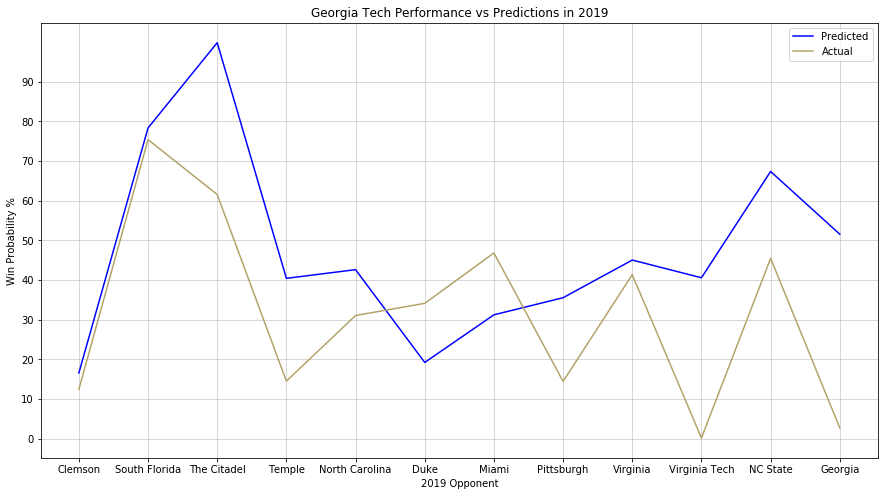

In [59]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

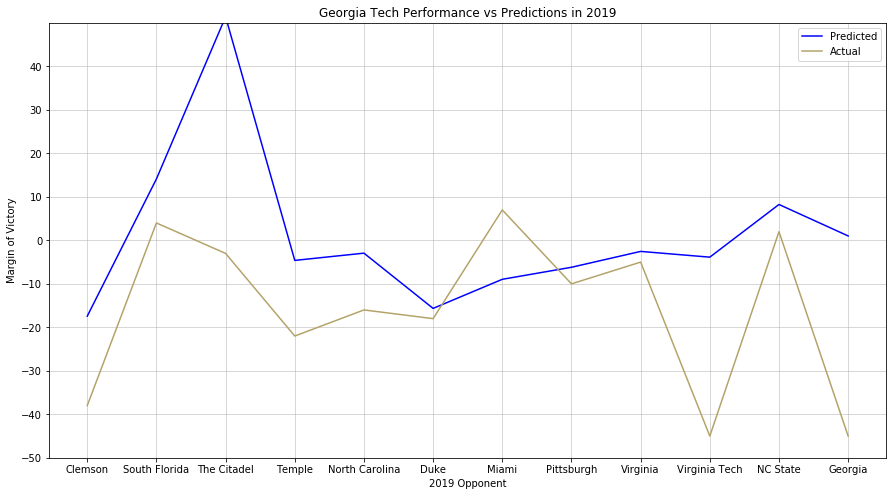

In [60]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 40.0 (exact value: 40.19210240144695)
Z score: 2.265239631043242
Win Prob for Georgia Tech: 98.83%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by -3.0 (exact value: -2.886417548354144)
Z score: -0.1833870355840951
Win Prob for South Florida: 42.72%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 4.0 (exact value: 3.5431460297908237)
Z score: 0.18207586450085403
Win Prob for Pittsburgh: 57.22%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 39.0 (exact value: 39.169971807011464)
Z score: 2.2071406937253655
Win Prob for Clemson: 98.63%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 36.0 (exact value: 36.234934661581)
Z sco

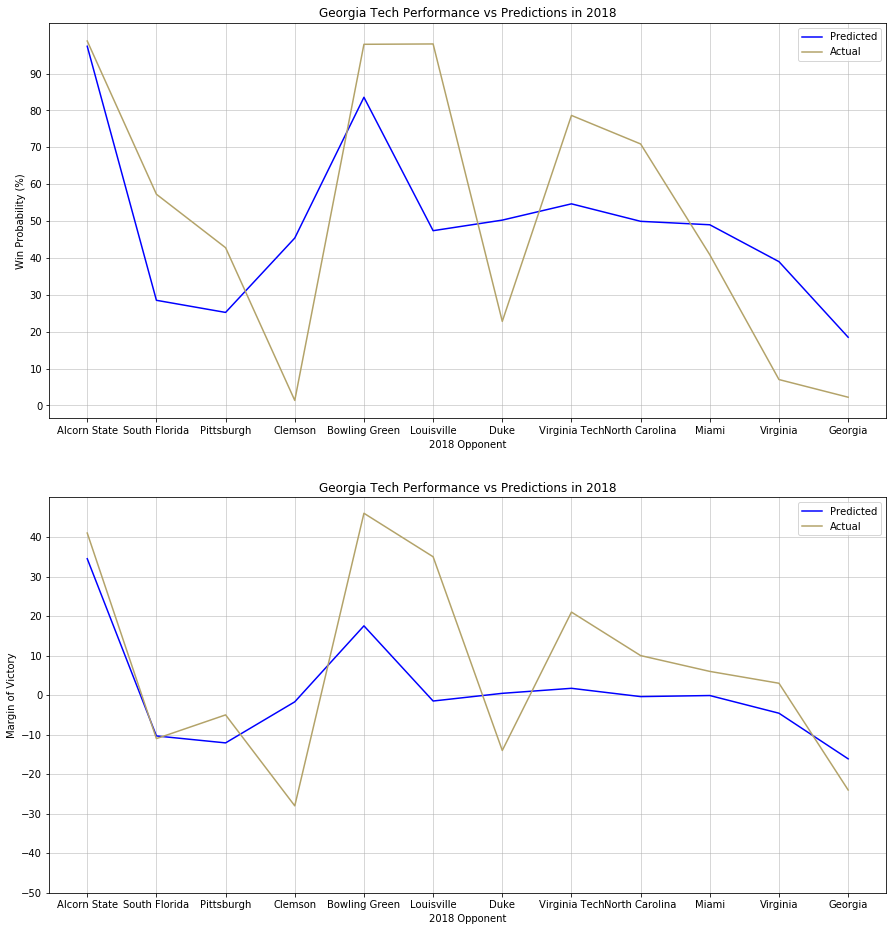

In [61]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability (%)')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

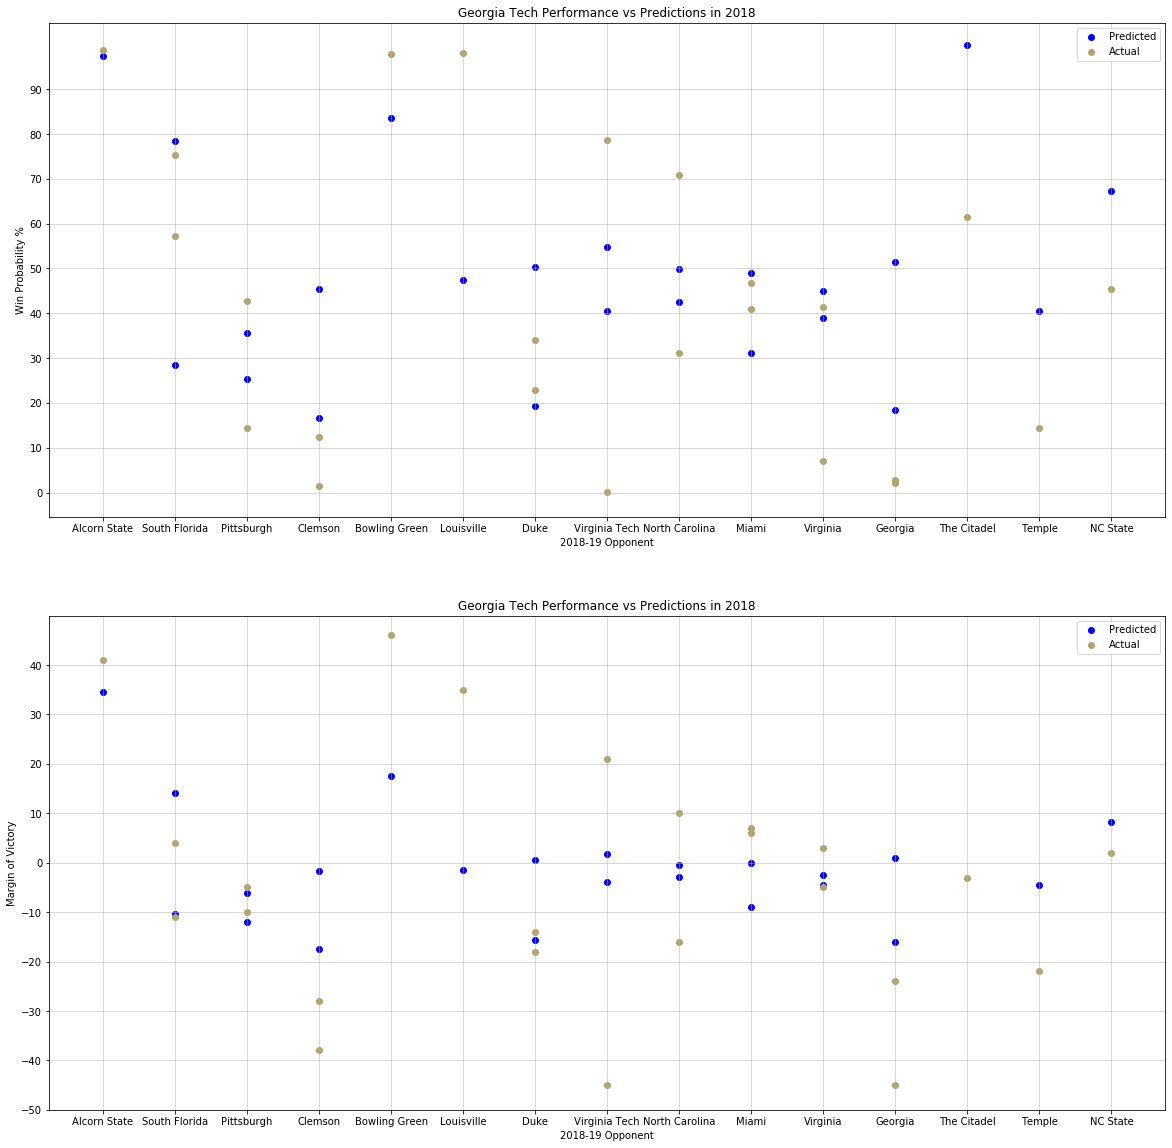

In [62]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [63]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.616487,0.415769,0.359345,0.287799,0.229654,0.209556,0.322511
2013,0.616487,1.000000,0.459092,0.304938,0.173862,0.227571,0.132408,0.294486
2014,0.415769,0.459092,1.000000,0.491518,0.322559,0.260599,0.275081,0.267057
2015,0.359345,0.304938,0.491518,1.000000,0.546439,0.423597,0.296930,0.334456
2016,0.287799,0.173862,0.322559,0.546439,1.000000,0.445569,0.309868,0.433263
2017,0.229654,0.227571,0.260599,0.423597,0.445569,1.000000,0.566744,0.392912
2018,0.209556,0.132408,0.275081,0.296930,0.309868,0.566744,1.000000,0.465453
2019,0.322511,0.294486,0.267057,0.334456,0.433263,0.392912,0.465453,1.000000


In [64]:
def round_sig_figs(i, n):
    return '{:g}'.format(float('{:.{p}g}'.format(i, p=n)))

def clean_prediction_prob_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    prob = predict_matchup(home_team, away_team, row.Year, 0, -1,(row.Site != "Neutral"), True)[0]
    if (row.Team == home_team):
        return prob
    else:
        return 1-prob

def clean_prediction_mov_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    mov = predict_matchup(home_team, away_team, row.Year, 0, -1, (row.Site != "Neutral"), True)[1]
    if (row.Team == home_team):
        return mov
    else:
        return -1 * mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame

opp_2020_df = pd.DataFrame(data={
    "Team" : ["Florida State","UCF","Syracuse","Louisville","Clemson","Boston College","Notre Dame","Pittsburgh","Miami","Duke","NC State"],
    "Site" : ["Away","Home","Away","Home","Home","Away","Home","Home","Away","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
# georgia_tech_2020.to_csv("results/gt-2020.csv", index=False, sep=",")
print(f"Expected 2nd order wins: {georgia_tech_2020.PredWinProb.sum() / 100}")
georgia_tech_2020

Expected 2nd order wins: 3.9194403176586676


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Florida State,Away,26.173280,-11.564406
1,2020,Georgia Tech,UCF,Home,40.666566,-3.814332
2,2020,Georgia Tech,Syracuse,Away,48.729173,-0.900414
3,2020,Georgia Tech,Louisville,Home,45.226928,-1.770023
4,2020,Georgia Tech,Clemson,Home,10.306496,-21.902475
5,2020,Georgia Tech,Boston College,Away,48.209379,-1.129808
6,2020,Georgia Tech,Notre Dame,Home,20.644898,-14.065273
7,2020,Georgia Tech,Pittsburgh,Home,36.726135,-5.626138
8,2020,Georgia Tech,Miami,Away,22.133117,-13.846082
9,2020,Georgia Tech,Duke,Home,46.720266,-1.108063


In [65]:
opp_2019_df = pd.DataFrame(data={
    "Team" : ["Clemson","South Florida","The Citadel","Temple","North Carolina","Duke","Miami","Pittsburgh","Virginia","Virginia Tech","NC State","Georgia"],
    "Site" : ["Away","Home","Home","Away","Home","Away","Away","Home","Away","Home","Home","Home"]
})
georgia_tech_2019 = generate_schedule_predictions("Georgia Tech", opp_2019_df, 2019)
print(f"Expected 2nd order wins: {georgia_tech_2019.PredWinProb.sum() / 100}")
georgia_tech_2019

Expected 2nd order wins: 4.9307737777702245


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2019,Georgia Tech,Clemson,Away,19.302393,-15.589570
1,2019,Georgia Tech,South Florida,Home,49.969524,0.326458
2,2019,Georgia Tech,The Citadel,Home,94.090559,27.827465
3,2019,Georgia Tech,Temple,Away,36.767094,-6.286806
4,2019,Georgia Tech,North Carolina,Home,50.208044,0.431643
5,2019,Georgia Tech,Duke,Away,36.671248,-6.331578
6,2019,Georgia Tech,Miami,Away,35.321919,-6.966165
7,2019,Georgia Tech,Pittsburgh,Home,43.065535,-2.733692
8,2019,Georgia Tech,Virginia,Away,33.942666,-7.623871
9,2019,Georgia Tech,Virginia Tech,Home,46.078624,-1.392181


In [66]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

Spreads imported: 17274


In [67]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [68]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 535 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 530 games with betting lines for 2013 season.
[Simulation] Creating projections for 530 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 528 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 488 games with betting lines for 2014 season.
[Simulation] Creating projections for 488 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 570 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 542 games with betting lines for 2015 season.
[Simulation] Creating projections for 542 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,398,132,0,0.750943
1,ATS,2013,297,226,7,0.560377
0,ML,2014,371,117,0,0.760246
1,ATS,2014,306,173,9,0.627049
0,ML,2015,424,118,0,0.782288
1,ATS,2015,336,192,14,0.619926
0,ML,2016,420,119,0,0.779221
1,ATS,2016,332,193,14,0.615955
0,ML,2017,456,149,0,0.753719
1,ATS,2017,336,251,18,0.555372


In [69]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ATS")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
ats_payout['pct_return'] = ats_payout.apply(lambda x: (x.net_payout / x.total_invested), axis=1)
print(f"Total earnings (2013-2019) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

Total earnings (2013-2019) if betting $5 per game: $3101.0


,pick_category,season,W,L,D,WinPct,total_invested,net_payout,avg_weekly_payout,pct_return
1,ATS,2013,297,226,7,0.560377,2650,242.0,15.125000,0.091321
1,ATS,2014,306,173,9,0.627049,2440,578.5,36.156250,0.237090
1,ATS,2015,336,192,14,0.619926,2710,624.0,41.600000,0.230258
1,ATS,2016,332,193,14,0.615955,2695,598.5,39.900000,0.222078
1,ATS,2017,336,251,18,0.555372,3025,299.5,19.966667,0.099008
1,ATS,2018,303,216,16,0.566355,2675,327.0,21.800000,0.122243
1,ATS,2019,347,237,10,0.584175,2970,431.5,28.766667,0.145286


In [70]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7695733612341336
Avg ATS Win %: 0.5898871909096005


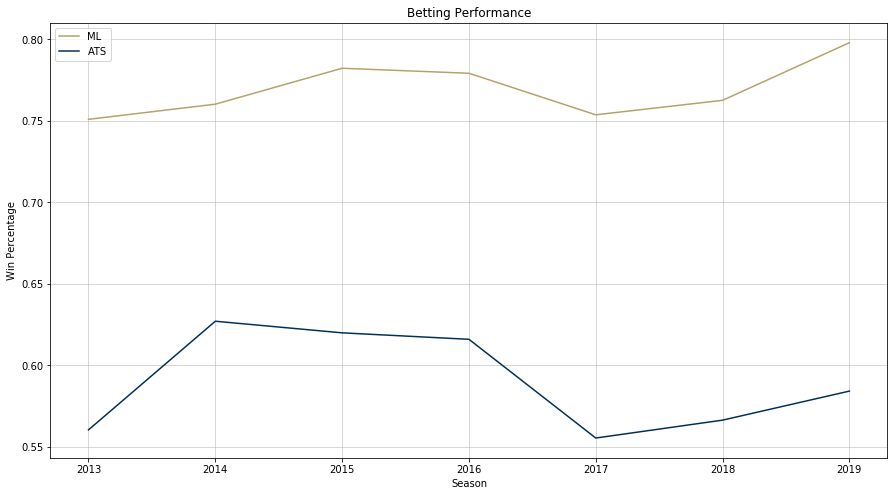

In [71]:
f, a = plt.subplots(1, figsize=(15, 8))
a.plot(historic_validation[(historic_validation.pick_category == "ML")].season, historic_validation[(historic_validation.pick_category == "ML")].WinPct, color='#B3a369', label="ML")
a.plot(historic_validation[(historic_validation.pick_category == "ATS")].season, historic_validation[(historic_validation.pick_category == "ATS")].WinPct, color='#003057', label="ATS")
a.set_title("Betting Performance")
a.grid(linestyle='-', linewidth=0.5)
a.set_xlabel('Season');
a.set_ylabel('Win Percentage');
a.legend();

In [72]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [73]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

[0.7104420237805154, 10.098283305531046]

In [74]:
# generate_win_prob(401135295, 2019)

In [75]:
# Rankings data
rank_data = pd.DataFrame()

for i in range(2012, 2020):
    ln = retrieveCfbDataFile('rankings',i)
    ln['year'] = i
    rank_data = rank_data.append(ln, sort=False)
    
print(f"Rankings imported: {len(rank_data)}")

def fix_ranking_name(poll):
    if ((poll == "Playoff Committee Rankings") | (poll == "BCS Standings")):
        return "BCS/CFP"
    elif (poll == "Coaches Poll"):
        return "Coaches"
    elif (poll == "AP Top 25"):
        return "AP"
    else:
        return "Unknown"
    
rank_data.poll = rank_data.poll.apply(lambda x: fix_ranking_name(x))
    
def retrieve_rank(x, title, week):
    r = rank_data[(rank_data.school == x.Team) & (rank_data.poll == title) & (x.Season == rank_data.season) & (rank_data.week == week)]
    if len(r) == 0:
        return None
    return stringify_entry(r['rank'])

org_season = stored_game_boxes.copy().groupby(['Team','Season'])
org_ratings = org_season.apply(lambda x: x['5FRDiff'].mean())
org_fr_year = org_ratings.reset_index()
org_fr_year.columns = ["Team",'Season','5FRDiff']
org_fr_year

org_tmp = org_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FRDiff', ascending=False)).reset_index(drop=True)

Rankings imported: 11864


In [76]:
def create_srs_for_year(season):
    terms = []
    solutions = []
    
    participants = opponent_game_ids[(opponent_game_ids.Season == season)].Team.drop_duplicates()
#     participants = participants.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
    participants = participants.to_list()
#     print(participants)
    for team in participants:
        row = []
        # get a list of team opponents
        opps = opponent_game_ids[(opponent_game_ids.Team == team) & (opponent_game_ids.Season == season)].Opponent.to_list()

        for opp in participants:
            if opp == team:
                # coefficient for the team should be 1
                row.append(1)
            elif opp in opps:
                # coefficient for opponents should be 1 over the number of opponents
                row.append(-1.0/len(opps))
            else:
                # teams not faced get a coefficient of 0
                row.append(0)

        terms.append(row)

        # average game spread on the other side of the equation
        solutions.append(org_tmp[(org_tmp.Team == team) & (org_tmp.Season == season)]['5FRDiff'].mean())

    slns = np.linalg.solve(np.array(terms), np.array(solutions))
    ratings = list(zip( participants, slns ))
    srs = pd.DataFrame(ratings, columns=['Team', '5FRSRS'])
    srs.sort_values(by='5FRSRS', ascending=False, inplace=True)
    srs['5FRSRSRank'] = range(1, len(srs)+1)
    return srs

gen_srs = create_srs_for_year(2019)
gen_srs

,Team,5FRSRS,5FRSRSRank
53,LSU,1.503016,1
2,Alabama,1.219208,2
77,Ohio State,1.131691,3
78,Oklahoma,0.934363,4
34,Georgia,0.900267,5
...,...,...,...
116,UTEP,-1.015524,125
14,Bowling Green,-1.079985,126
25,Connecticut,-1.149646,127
1,Akron,-1.397288,128


In [77]:
generate_win_prob(401234563, 2020)

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 10.0 (exact value: 9.972902670964261)
Z score: 0.5475497384837087
Win Prob for Georgia Tech: 70.80%
---


[0.7079994454547028, 3.0]